In [17]:
from src.setup import *
from src import host
from src import common
from Pyhattan import FormatData, GenerateManhattan

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

In this notebook, we'll do a complete GWAS **from strach**, i.e. beginning with the raw, dirty data, and focus on asian individuals. The principle is to re-run all quality control steps to get a **new dataset** that is not biased by individuals that won't be included in the study. For instance, MAF filtering can be biased when subpopulations with different allele frequencies are present. We also want to avoid such biases with missing values and chromosomes, for example. 

The path to the clean dataset for this study is defined by `PATH_ASIANS_GWAS`.

###### Selection of individuals

The clustering that was done in the previous notebook did not provide any satisfying result. Thus we will use a list of individuals that belong to a same cluster, according to the same clustering algorithm (hierarchichal, ward) but done with R (thanks to Sina for providing me the list). This list is specified by `PATH_CLUSTERING_ASIANS`.

###### Plan

1. Prepare dataset for QC: Exclude variants with 100% missing rate, remove relevant chromosomes, keep only relevant individuals, create **new (dirty) dataset**.
1. Quality control
    1. Missing values (variants), create intermediate dataset
    1. Missing values (individuals)
    1. MAF filtering, HWE tests
1. Association analyses

We want to force the order of missingness filtering (first variants, then individuals, i.e. unlike plink does when both commands are run at the same time), thus we create an intermediate dataset after the filtering of missing variants.

# Preparation

At the end of this section, we create a new dataset that is ready for **unbiased** quality control. The filters here are :

* Remove variants with 100% missingness
* Keep only autosomes
* Keep only asian related individuals (a cluster)

In [4]:
# Define the path for this new dataset
path_prepared_dataset = PATH_PLINK_DATA+"asians_gwas_prepared"

In [9]:
# 1. Remove variants with 100% missing rate
host.run_plink("--geno 0.999999999 " + DEFAULT_CHROMOSOME_EXCLUSION_GWAS + \
               " --keep " + PATH_CLUSTERING_ASIANS + " --make-bed",
               file=PATH_HOST_RAW_PLINK_DATA, out=path_prepared_dataset, extension='bed',
               log_name='asians_gwas_0_data_preparation');

Running 'plink2 --bfile data/raw/wes_plink/hbv_gilead_bcftools --out data/plink/asians_gwas_prepared --geno 0.999999999 --not-chr 0 X Y XY MT --keep data/clustering_asians_gwas.txt --make-bed '
Log written to 'data/plink/log/asians_gwas_data_preparation.log'


# Quality control

We start the QC with he dataset defined by `path_prepared_dataset`.

###### Missing report



Running 'plink2 --bfile data/plink/asians_gwas_prepared --out data/plink/asians_gwas_prepared --missing '
Log written to 'data/plink/log/asians_gwas_missing.log'


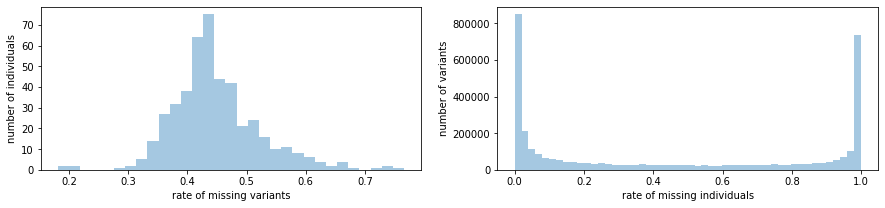

In [14]:
host.run_plink("--missing", file=path_prepared_dataset, out=path_prepared_dataset, 
               extension='vmiss', log_name='asians_gwas_1_missing')
common.plot_missing(path_prepared_dataset)

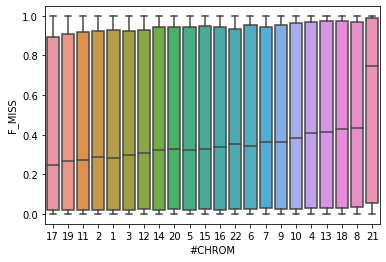

In [19]:
dtype = {'F_MISS':float, 'ID':str, '#CHROM':str}
df_miss_var = pd.read_csv(path_prepared_dataset+'.vmiss', sep='\s+', usecols=['#CHROM', 'ID', 'F_MISS'], dtype=dtype)
df_miss_chr = df_miss_var.groupby('#CHROM').mean()
sns.boxplot(x='#CHROM', y='F_MISS', data=df_miss_var, order=df_miss_chr.sort_values(by='F_MISS').index);

###### Filter variants

In [20]:
# 1. Path for this intermediate dataset
path_intermed_dataset = PATH_PLINK_DATA+"asians_gwas_intermed_QC"

In [21]:
# 2. Filter
host.run_plink("--geno " + str(THRESHOLD_MISSING_VARIANTS) + " --make-bed", file=path_prepared_dataset,
              out=path_intermed_dataset, extension='bed', log_name='asians_gwas_2_intermedQC');

Running 'plink2 --bfile data/plink/asians_gwas_prepared --out data/plink/asians_gwas_QC_intermed --geno 0.01 --make-bed '
Log written to 'data/plink/log/asians_gwas_intermedQC.log'


###### Filter individuals

In [23]:
path_missingness_treated_dataset = PATH_PLINK_DATA+"asians_gwas_missingness_treated"

In [25]:
host.run_plink("--mind " + str(THRESHOLD_MISSING_INDIVIDUALS) + " --make-bed", file=path_intermed_dataset,
              out=path_missingness_treated_dataset, extension='bed', log_name='asians_gwas_3_miss_treated');

Running 'plink2 --bfile data/plink/asians_gwas_QC_intermed --out data/plink/asians_gwas_missingness_treated --mind 0.1 --make-bed '
Log written to 'data/plink/log/asians_gwas_miss_treated.log'


###### Missing report of missingness treated dataset

Running 'plink2 --bfile data/plink/asians_gwas_missingness_treated --out data/plink/asians_gwas_missingness_treated --missing '
Log written to 'data/plink/log/asians_gwas_missing.log'


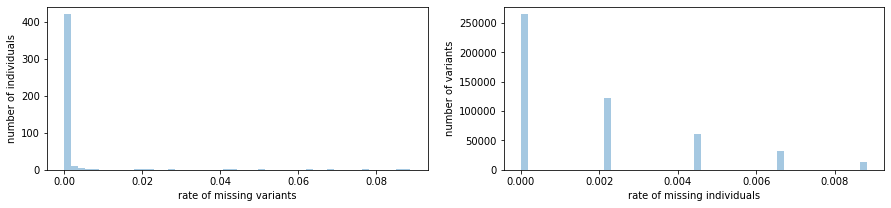

In [27]:
host.run_plink("--missing", file=path_missingness_treated_dataset, out=path_missingness_treated_dataset, 
               extension='vmiss', log_name='asians_gwas_4_missing')
common.plot_missing(path_missingness_treated_dataset)

###### MAF and HWE

This is the last step of QC, the datset will be ready for association analyses.

In [29]:
host.run_plink("--maf 0.01 --hwe 1e-6 --make-bed", file=path_missingness_treated_dataset, extension='bed',
              out=PATH_ASIANS_GWAS, log_name='asians_gwas_5_maf_hwe');

Running 'plink2 --bfile data/plink/asians_gwas_missingness_treated --out data/plink/asians_gwas --maf 0.01 --hwe 1e-6 --make-bed '
Log written to 'data/plink/log/asians_gwas_maf_hwe.log'


***
# Association analyses

## Monovariate model

Here the predictor is the genotype of each individual.

In [8]:
common.write_phenotypes(PATH_ASIANS_GWAS, phenotype=('S', 35, 'R'), output_path=PATH_WORKING_PHENOTYPES)
host.run_assoc(binary=True, exclude_chrs=None, file=PATH_ASIANS_GWAS);

453 individuals written to 'data/working_pheno'
0 were filtered out based on the criteria None
The phenotype '('S', 35, 'R')' was included.
Running 'plink2 --bfile data/plink/asians_gwas --out data/plink/asians_gwas --allow-no-sex --logistic --1 --pheno data/working_pheno --keep data/working_pheno '
Log written to 'data/plink/log/assoc.log'


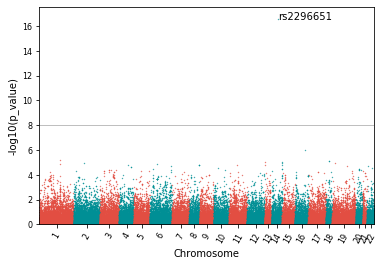

In [10]:
data = FormatData(PATH_ASIANS_GWAS+'.S_35_R.glm.logistic', sep='\s+', chromosome='#CHROM', 
                  p_value='P')
GenerateManhattan(data, refSNP='ID', significance=8)

In [11]:
common.write_phenotypes(PATH_ASIANS_GWAS, phenotype=('PC', 160, 'A'), output_path=PATH_WORKING_PHENOTYPES)
host.run_assoc(binary=True, exclude_chrs=None, file=PATH_ASIANS_GWAS);

453 individuals written to 'data/working_pheno'
0 were filtered out based on the criteria None
The phenotype '('PC', 160, 'A')' was included.
Running 'plink2 --bfile data/plink/asians_gwas --out data/plink/asians_gwas --allow-no-sex --logistic --1 --pheno data/working_pheno --keep data/working_pheno '
Log written to 'data/plink/log/assoc.log'


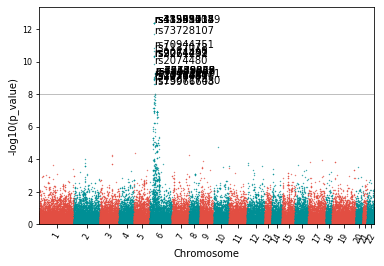

In [13]:
data = FormatData(PATH_ASIANS_GWAS+'.PC_160_A.glm.logistic', sep='\s+', chromosome='#CHROM', 
                  p_value='P')
GenerateManhattan(data, refSNP='ID', significance=8)

***
## Multivariate model

From [plink doc](https://www.cog-genomics.org/plink/1.9/input#covar):

> `--covar` designates the file to load covariates from. The file format is the same as for --pheno. The main phenotype is no longer set to missing when a covariate value is missing; instead, this only happens to the temporary phenotype copies used by e.g. the linear/logistic regression routine.
>
>Categorical covariates are now directly supported. Any nonnumeric string ('NA' and 'nan' are considered to be numbers for this purpose) is treated as a categorical covariate name.
>
>`--covar-name` works like --pheno-name. It can now be used without --covar (in which case the --pheno or .psam file is the target).
>
>`--covar-col-nums` works like --pheno-col-nums, and refers to the --pheno file when --covar is not specified.
>
>When no primary header line is present, covariates are assigned the names 'COVAR1', 'COVAR2', etc.

We'll use the `write_covariates` together with `write_phenotypes` to write the predictors, covariates and response variables. Since the covariates file format is very similar to the phenotypes file format, the function writing covariates itself calls the function that writes phenotypes.

We will write all amino acids in the phenotype file and plink will automatically loop over each amino acid. Thus we end up with N association tables (N = number of viral amino acid) that we will filter for significant associations.

### Writing covariates

We want to include age, sex, host principal components and viral principal components as covariates. 

###### Compute PCs of the new dataset


In [15]:
host.run_plink("--pca 6", file=PATH_ASIANS_GWAS, out=PATH_ASIANS_GWAS, extension='eigenval',
              log_name='asians_gwas_6_pca');

run_plink: command '--pca 6', the file 'data/plink/asians_gwas.eigenval' already exists (force is set to False).


In [19]:
common.write_covariates(PATH_ASIANS_GWAS, PATH_WORKING_COVARIATES, host_pcs=PATH_ASIANS_GWAS+'.eigenvec',
                       virus_pcs=PATH_VIRAL_DATA_PCS)

453 individuals written to 'None'
0 were filtered out based on the criteria None
The covariates '['AGE', 'SEX']' was included.
           FID        IID       AGE SEX       PC1       PC2       PC3  \
0    igm160019  igm160019  1.213750   0 -0.005812  0.044597 -0.006666   
1    igm160020  igm160020 -0.603111   1 -0.000727  0.045054 -0.018571   
2    igm160022  igm160022  1.040715   1  0.015620 -0.041837  0.016008   
3    igm160023  igm160023  0.435095   1  0.013709 -0.056627 -0.016440   
4    igm160024  igm160024  0.089027   1  0.022062 -0.056051  0.017139   
..         ...        ...       ...  ..       ...       ...       ...   
448  igm160902  igm160902 -0.343559   0 -0.061239  0.016138 -0.003824   
449  igm160903  igm160903 -0.257042   0  0.022835 -0.058151  0.011166   
450  igm160904  igm160904 -0.516593   1  0.009402 -0.062110 -0.029718   
451  igm160905  igm160905  0.608130   1  0.022381 -0.056653 -0.007155   
452  igm160906  igm160906 -0.430076   0  0.016104 -0.049015  0.005653 

In [20]:
with open(PATH_VIRAL_DATA_PCS, 'rb') as file:
    df = pickle.load(file)
    
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-5.377414,-0.207781,1.579049,4.562019,-0.481904,1.114517,0.073100,-0.776939,-0.339956,-0.250245,0.205982,1.549602,-1.839217,1.143221,0.875285,2.380655,-0.300745,-0.462211,-0.884616,-0.247447
1,5.721085,10.141139,-1.083932,0.225093,-0.584423,0.767729,0.167402,-0.283901,-0.372354,-0.202632,0.153544,0.146649,-0.114213,-0.279144,-0.069169,-0.361755,-0.401909,0.575924,-1.237060,-0.048400
2,9.197649,-6.671450,-0.785799,0.153197,-0.988649,-0.223622,1.426021,1.609175,-0.097849,-0.125818,-0.513152,0.125248,-0.114441,1.011189,0.846574,-0.936671,-1.036300,-0.472870,0.041905,-0.499606
3,1.131377,1.253641,8.780197,-4.058757,0.271586,1.125663,-0.200803,-1.945523,-0.760853,-0.933417,-1.495722,3.827834,2.424548,1.404783,-0.692828,-0.344864,0.027846,-0.458906,0.097047,0.193413
4,-5.291480,-0.862162,-1.836891,-1.960574,0.725195,-1.152367,0.023001,0.576249,-0.858329,-0.618045,0.119633,0.031655,0.588926,-0.222193,0.133984,0.110586,-0.534141,0.006810,-0.555542,1.484600
5,1.296937,1.470520,9.994165,-5.354455,-0.819891,-1.244002,-0.379415,0.637667,0.159145,0.644239,0.926674,-1.790205,-1.045274,0.533061,0.904127,0.119952,-0.877291,-0.625083,-0.112861,0.360569
6,5.340501,8.821682,-0.850061,0.123120,0.454117,3.268800,-3.108526,3.117815,-0.123660,-0.009783,-0.719287,0.548674,-0.132468,-0.093546,0.311174,0.413603,0.633126,0.017147,-0.074884,-0.280349
7,-5.542799,-1.273928,-1.444885,-1.675697,0.515622,-1.395003,-0.437570,0.812255,-1.180610,-0.677883,0.303322,-0.064693,0.806930,-0.303479,-0.198296,-0.253918,-0.829328,-0.492764,-0.221453,0.134594
8,-5.717421,-0.975455,-1.743187,-1.675697,-0.468177,2.015439,0.409120,-0.758055,1.173860,0.223476,-0.218884,-0.055897,-0.128781,0.418730,0.230360,-0.378837,-0.044200,-0.324425,0.539179,-0.368638
9,-4.807734,-0.870292,-1.018253,-2.295716,0.505416,-1.721004,-1.453423,0.684126,-0.667759,0.698547,-0.053620,0.404634,-1.332864,1.035349,-2.909277,1.043684,-0.861746,1.754061,1.496328,-1.016174
